In [ ]:
!pip install textdistance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import nltk
import random
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from textdistance import levenshtein
from nltk.tokenize import RegexpTokenizer
from nltk import everygrams
from pathlib import Path
from typing import Dict, List

In [ ]:
ENC_TEXT = "დჳჵჂႨშႼႨშჂხჂჲდႨსႹႭჾႣჵისႼჰႨჂჵჂႨႲႹႧჲჂႨსႹႭჾႣჵისႼჰႨჲდႩჳჲႨჇႨႠჲႹქႹႨჳႹႹჱჶდსჂႽႨႩႹჲႹႭႼჰႨჵდქႩႹႨႲႭႹႧჂჲႣჲიႨჳႩႹႭდდႨშჳდქႹႨშႼႨშჳდႨჳხდჵႣჵჂႨႲႭႣშჂჵისႹႨჂႨႲႹჵჇႧჂჲდႨჾႣႩჳჂჾႣჵისႼჰႨჱႣჵჵႨეႣႨႲႹჳჵდხსდდႨႧდჲშდႭჲႹდႨეႣხႣსჂდႨႩჇႭჳႣႨႾႹჲႽႨႩႹსდႧსႹႨႽႨსჂႧდქႹႨსდႨႹჱდჶႣნ"
MAIN_ALPHABET = "".join(list(set(ENC_TEXT)))

# Полезные функции

In [ ]:
RU = " абвгдежзийклмнопрстуфхцчшщъыьэюяё"

def clean_text(corpora: str, alphabet: str = RU):
    tokenizer = RegexpTokenizer(r'\w+')
    corpora = corpora.lower()
    alpha_corpora = "".join([ch for ch in corpora if ch in alphabet])
    return " ".join(tokenizer.tokenize(alpha_corpora))


def calc_statistics(corpora: str, gram_len: int = 2):
    if gram_len > 1:
        raw_ngrams = everygrams(corpora, min_len=gram_len, max_len=gram_len)
        ngrams = ["".join(ngram) for ngram in raw_ngrams]
    else:
        ngrams = corpora
    
    vol = sum(Counter(ngrams).values())
    return {gr: count / vol for gr, count in Counter(ngrams).items()}


def generate_map(alphabet: str = RU):
    shuffled = list(alphabet)
    random.shuffle(shuffled)
    return {orig: rep for orig, rep in zip(alphabet, shuffled)}


def encode(text: str, mapping: Dict[str, str], dummy: str = "ё"):
    return "".join([mapping.get(ch, dummy) for ch in text])


def calc_lev_loss(text1: str, text2: str):
    norm = max(len(text1), len(text2))
    metric = levenshtein(text1, text2)
    print(f"Absolute metric: {metric}")
    print(f"Relative metric: {metric / norm:.3f}")
    return metric, metric / norm

# N-grams



Для декодера будем делать следующее: 
- идем по n-грамам закодированного сообщения;
- для каждого смотрим какие буквы мы уже научились декодировать;
- фильтруем по этим буквам, и среди полученных ищем ближайший n-gram по частоте;
- обновляем в декодере буквы, если n-gram окался ближе или буквы ещё не добавлялись.

In [ ]:
def create_decoder(
    corpora_stats: Dict[str, float],
    text_stats: Dict[str, float],
    encoded_text: str,
    gram_len: int = 1,
):
    enc_df = pd.DataFrame(text_stats.items(), columns=["gram", "freq"])
    enc_df = pd.concat([enc_df, enc_df.gram.str.split("", expand=True).iloc[:, 1:-1]], axis=1)
    dec_df = pd.DataFrame(corpora_stats.items(), columns=["gram", "freq"])
    dec_df = pd.concat([dec_df, dec_df.gram.str.split("", expand=True).iloc[:, 1:-1]], axis=1)

    assert enc_df.shape[1] == gram_len + 2, "Incorrect gram_len."
    assert dec_df.shape[1] == gram_len + 2, "Incorrect gram_len."
    
    decoder = {}
    dec_frecs = {}

    for ngram in [encoded_text[i:i+gram_len] for i in range(0, len(encoded_text) - gram_len + 1)]:
        filter = []
        dec_filt = dec_df
        ngram_freq = text_stats[ngram]

        for pos, alpha in enumerate(ngram, start=1):
            if alpha in decoder:
                dec_filt = dec_filt[dec_filt[pos] == decoder[alpha]]

            if len(dec_filt) == 0:
                break
            
            vals = dec_filt['freq'].values
            dists = np.abs(vals - ngram_freq)
            fpos = np.argmin(dists)

            decoded_ngram = dec_filt.iloc[fpos, :]['gram']
            decoded_val = dists[fpos]

            for enc_a, dec_a in zip(ngram, decoded_ngram):
                if (enc_a not in decoder) or (dec_frecs[enc_a] < decoded_val):
                    decoder[enc_a] = dec_a
                    dec_frecs[enc_a] = decoded_val
    
    return decoder

In [ ]:
nltk.download('punkt')
corpora_parent = Path("/content/corpora")
corpora_list = []

for text_pth in corpora_parent.glob("**/*"):
    if text_pth.is_file():
        print(text_pth)
        if "WarAndPeaceEng" not in str(text_pth):
            with open(text_pth, 'r') as ftext:
                corpora_list.extend(ftext.readlines())

corpora = clean_text(" ".join(corpora_list))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/content/corpora/WarAndPeace.txt
/content/corpora/AnnaKarenina.txt


In [ ]:
text = "Вряд ли в результате получилась такая уж хорошая расшифровка, разве что если вы брали в качестве тестовых данных целые рассказы. Но и Шерлок Холмс был не так уж прост: после буквы E, которая действительно выделяется частотой, дальше он анализировал уже конкретные слова и пытался угадать, какими они могли бы быть. Я не знаю, как запрограммировать такой интуитивный анализ, так что давайте просто сделаем следующий логический шаг"
random_mapper = generate_map()
text = clean_text(text)
enc_text = encode(text, random_mapper)

In [ ]:
losses = []

for gram_len in range(1, 5): 
    print(f"n-gram length: {gram_len}")
    corpora_stats = calc_statistics(corpora, gram_len=gram_len)
    text_stats = calc_statistics(enc_text, gram_len=gram_len)

    decode_mapper = create_decoder(
        corpora_stats,
        text_stats,
        enc_text,
        gram_len=gram_len,
    )

    dec_text = encode(enc_text, decode_mapper)
    losses.append(calc_lev_loss(text, dec_text)[1])
    print(dec_text[:100])
    print()

n-gram length: 1
Absolute metric: 279
Relative metric: 0.667
вляп ии в лньпиьаоан баипбииось аолоя пш жалачоя лосчищлавло лоьвн баа нсии вк члоии в лобнсавн анса

n-gram length: 2
Absolute metric: 284
Relative metric: 0.679
 тлд л    тадилярара иллие лаля ра ал ил елтляал таля жтл  а тад а ерл алл   к итал     аеалр а ралр

n-gram length: 3
Absolute metric: 361
Relative metric: 0.864
сньласкасаннассн н наннсснкснкна нтньастанннноньаннкок ннстнаннаснан нанкскаснанннскасатнннк сна нк 

n-gram length: 4
Absolute metric: 355
Relative metric: 0.849
нсе ттчтнтсикотоо оит ттоочт лото о ето тотстя етс лячестно тс книтооттилтчтнйтос тчтнто оилонитоило



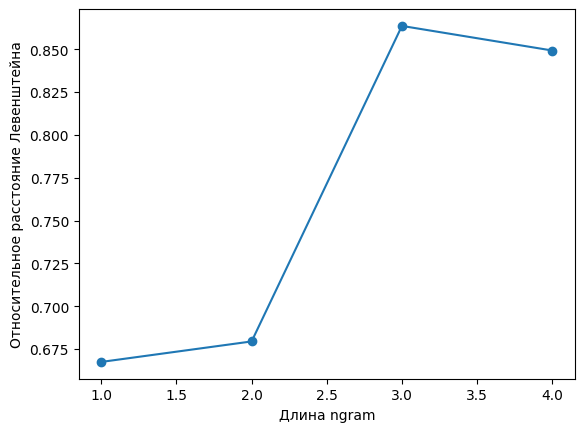

In [ ]:
plt.plot(list(range(1, 5)), losses, marker='o')
plt.ylabel("Относительное расстояние Левенштейна")
plt.xlabel("Длина ngram")
plt.show()

Попробуем что-то получить на основном тексте задания.

In [ ]:
corpora_stats = calc_statistics(corpora, gram_len=1)
MAIN_STATS = calc_statistics(ENC_TEXT, gram_len=1)
decode_mapper = create_decoder(
        corpora_stats,
        MAIN_STATS,
        ENC_TEXT,
        gram_len=1,
    )

dec_text = encode(ENC_TEXT, decode_mapper)
print(dec_text)

осна кд каьато норьннундь ана уодта норьннундь токст ч ютоьо соочйонач котордь ноько уродатнту скороо ксоьо кд ксо сьоннна урнкануно а уончдато ьнксаьннундь чннн йн уосноьноо доткортоо йньннао кчрсн юотч конодно ч надоьо но очойню


# MCMC

В качесве вероятности возьмём частоту появления н-грам. Правдоподобие - сумма логарифмов этиз веростностей. Применять модель будем если эта величина больше, чем правдоподобие вычисленное на предыдущем шаге. Если это не так, что с вероятностью отношения вероятностей принимаем новый декодер.

In [ ]:
def calc_statistics(corpora: str, gram_len: int = 2):
    if gram_len > 1:
        raw_ngrams = everygrams(corpora, min_len=gram_len, max_len=gram_len)
        ngrams = ["".join(ngram) for ngram in raw_ngrams]
    else:
        ngrams = corpora
    
    vol = sum(Counter(ngrams).values())
    return {gr: count / vol for gr, count in Counter(ngrams).items()}, 1 / vol


def calc_log_proba(
    enc_text: str,
    mapping: Dict[str, str],
    corpora_stats: Dict[str, float],
    gram_len: int,
    min_p: float,
):
    dec_text = encode(enc_text, mapping)
    log_p = 0.0

    for ngram in [dec_text[i:i+gram_len] for i in range(0, len(dec_text) - gram_len + 1)]:
        ngram_p = corpora_stats.get(ngram, min_p)
        log_p += np.log(ngram_p)
    return log_p

In [ ]:
from tqdm.notebook import tqdm
from time import sleep


def construct_mapper(alpha_enc: List[str], alpha_dec: List[str]):
    max_p = len(alpha_enc)
    return {enc: dec for enc, dec in zip(alpha_enc, alpha_dec[:max_p])}


def MC_step(
    enc_text: str,
    corpora_stats: Dict[str, float],
    alpha_enc: str,
    alpha_dec: str,
    iters: int,
    gram_len: int,
    min_p: float,
):
    alpha_enc = list(alpha_enc)
    cur_alpha = list(alpha_dec)
    mapper = construct_mapper(alpha_enc, cur_alpha)
    log_proba = calc_log_proba(
        enc_text, mapper, corpora_stats, gram_len, min_p
    )

    for _ in range(iters):
        swap_alpha = cur_alpha.copy()
        i1, i2 = np.random.choice(len(swap_alpha), replace=False, size=2)
        swap_alpha[i1], swap_alpha[i2] = swap_alpha[i2], swap_alpha[i1]
        new_mapper = construct_mapper(alpha_enc, swap_alpha)
        new_log_proba = calc_log_proba(
            enc_text, new_mapper, corpora_stats, gram_len, min_p
        )
        proba_accept = np.exp(new_log_proba - log_proba)

        if (new_log_proba > log_proba) or (proba_accept > np.random.rand()):
            cur_alpha = swap_alpha.copy()
            log_proba = new_log_proba
            mapper = new_mapper.copy()
    
    return mapper, log_proba



def MCMC(
    enc_text: str,
    corpora_stats: Dict[str, float],
    n_epochs: int,
    n_swaps: int,
    gram_len: int,
    min_p: float,
    alphabet_enc: str,
    alphabet_dec: str = RU,
):
    
    mapper = construct_mapper(
        list(alphabet_enc),
        list(alphabet_dec),
    )

    log_proba = calc_log_proba(
        enc_text,
        mapper,
        corpora_stats,
        gram_len,
        min_p,
    )

    trange = tqdm(range(n_epochs))

    for ep in trange:
        trange.set_description(f"Loss = {log_proba}")
        new_mapper, new_log_proba = MC_step(
            enc_text,
            corpora_stats,
            alphabet_enc,
            alphabet_dec,
            n_swaps,
            gram_len,
            min_p,
        )

        if new_log_proba > log_proba:
            log_proba = new_log_proba
            mapper = new_mapper.copy()
    
    return mapper


In [ ]:
text = "Вряд ли в результате получилась такая уж хорошая расшифровка, разве что если вы брали в качестве тестовых данных целые рассказы. Но и Шерлок Холмс был не так уж прост: после буквы E, которая действительно выделяется частотой, дальше он анализировал уже конкретные слова и пытался угадать, какими они могли бы быть. Я не знаю, как запрограммировать такой интуитивный анализ, так что давайте просто сделаем следующий логический шаг"
random_mapper = generate_map()
text = clean_text(text)
enc_text = encode(text, random_mapper)
corpora_stats, min_p = calc_statistics(corpora, gram_len=2)


In [ ]:
mapper = MCMC(
    enc_text,
    corpora_stats,
    n_epochs=5,
    n_swaps=10000,
    gram_len=2,
    min_p=min_p,
    alphabet_enc=RU,
)

encode(enc_text, mapper)

  0%|          | 0/5 [00:00<?, ?it/s]

'врям ли в результате получилась такая уж хорошая расшифровка разве что если вы брали в качестве тестовых манных целые рассказы но и шерлок холдс был не так уж прост после буквы которая мействительно вымеляется частотой мальше он анализировал уже конкретные слова и пытался угамать какиди они догли бы быть я не знаю как запрограддировать такой интуитивный анализ так что мавайте просто смелаед слемующий логический шаг'

In [ ]:
corpora_stats, min_p = calc_statistics(corpora, gram_len=2)

mapper = MCMC(
    ENC_TEXT,
    corpora_stats,
    n_epochs=5,
    n_swaps=10000,
    gram_len=2,
    alphabet_enc=MAIN_ALPHABET,
    min_p=min_p,
)

encode(ENC_TEXT, mapper)

  0%|          | 0/10 [00:00<?, ?it/s]

'если вы вимите нордальный или почти нордальный текст у этого сообщения который легко прочитать скорее всего вы все смелали правильно и получите даксидальный балл за послемнее четвертое замание курса хотя конечно я ничего не обещаж'

In [ ]:
kek = "если вы видите нормальный или почти нормальный текст у этого сообщения который легко прочитать скорее всего вы все сделали правильно и получите максимальный балл за последнее четвертое задание курса хотя конечно я ничего не обещал"
calc_lev_loss(kek, encode(ENC_TEXT, mapper))

Absolute metric: 9
Relative metric: 0.039


(9, 0.0391304347826087)

# Зависимость от размера: текста, n-gramm

In [ ]:
from collections import defaultdict

In [ ]:
full_text = "Я в своем познании настолько преисполнился, что я как будто бы уже сто триллионов миллиардов лет проживаю на триллионах и триллионах таких же планет, как эта Земля, мне этот мир абсолютно понятен, и я здесь ищу только одного - покоя, умиротворения и вот этой гармонии, от слияния с бесконечно вечным, от созерцания великого фрактального подобия и от вот этого замечательного всеединства существа, бесконечно вечного, куда ни посмотри, хоть вглубь - бесконечно малое, хоть ввысь - бесконечное большое, понимаешь? А ты мне опять со своим вот этим, иди суетись дальше, это твоё распределение, это твой путь и твой горизонт познания и ощущения твоей природы, он несоизмеримо мелок по сравнению с моим, понимаешь? Я как будто бы уже давно глубокий старец, бессмертный, ну или там уже почти бессмертный, который на этой планете от её самого зарождения, ещё когда только Солнце только-только сформировалось как звезда, и вот это газопылевое облако, вот, после взрыва, Солнца, когда оно вспыхнуло, как звезда, начало формировать вот эти коацерваты, планеты, понимаешь, я на этой Земле уже как будто почти пять миллиардов лет живу и знаю её вдоль и поперёк этот весь мир, а ты мне какие-то... мне не важно на твои тачки, на твои яхты, на твои квартиры, там, на твоё благо. Я был на этой планете бесконечным множеством, и круче Цезаря, и круче Гитлера, и круче всех великих, понимаешь, был, а где-то был конченым говном, ещё хуже, чем здесь. Я множество этих состояний чувствую. Где-то я был больше подобен растению, где-то я больше был подобен птице, там, червю, где-то был просто сгусток камня, это всё есть душа, понимаешь? Она имеет грани подобия совершенно многообразные, бесконечное множество. Но тебе этого не понять, поэтому ты езжай себе , мы в этом мире как бы живем разными ощущениями и разными стремлениями, соответственно, разное наше и место, разное и наше распределение. Тебе я желаю все самые крутые тачки чтоб были у тебя, и все самые лучше самки, если мало идей, обращайся ко мне, я тебе на каждую твою идею предложу сотню триллионов, как всё делать. Ну а я всё, я иду как глубокий старец,узревший вечное, прикоснувшийся к Божественному, сам стал богоподобен и устремлен в это бесконечное, и который в умиротворении, покое, гармонии, благодати, в этом сокровенном блаженстве пребывает, вовлеченный во всё и во вся, понимаешь, вот и всё, в этом наша разница. Так что я иду любоваться мирозданием, а ты идёшь преисполняться в ГРАНЯХ каких-то, вот и вся разница, понимаешь, ты не зришь это вечное бесконечное, оно тебе не нужно. Ну зато ты, так сказать, более активен, как вот этот дятел долбящий, или муравей, который очень активен в своей стезе, поэтому давай, наши пути здесь, конечно, имеют грани подобия, потому что всё едино, но я-то тебя прекрасно понимаю, а вот ты меня - вряд ли, потому что я как бы тебя в себе содержу, всю твою природу, она составляет одну маленькую там песчиночку, от того что есть во мне, вот и всё, поэтому давай, ступай, езжай, а я пошел наслаждаться прекрасным осенним закатом на берегу теплой южной реки. Всё, ступай, и я пойду."

In [ ]:
sent = [clean_text(text) for text in full_text.split('.')]
train, test = [" ".join(sent[:6]).strip(), " ".join(sent[6:12]).strip()]

In [ ]:
gram_lens = [2, 3, 5, 7]

def experiment(
    train: str,
    test: str,
    gram_lens: List[str],
    corpora: str,
    iters: int = 10,
    n_epochs: int = 2,
    n_swaps: int = 1000,
):
    res = defaultdict(lambda: defaultdict(list))
    for gram_len in gram_lens:
        print(f"{gram_len}-gram")
        corpora_stats, min_p = calc_statistics(corpora, gram_len)
        for i in tqdm(range(iters)):
            random_mapper = generate_map()
            enc_train = encode(train, random_mapper)
            enc_test = encode(test, random_mapper)
            dec_mapper = MCMC(
                enc_train,
                corpora_stats,
                n_epochs=n_epochs,
                n_swaps=n_swaps,
                gram_len=gram_len,
                alphabet_enc=RU,
                min_p=min_p,
            )
            dec_train = encode(enc_train, dec_mapper)
            dec_test = encode(enc_test, dec_mapper)
            loss_train = calc_lev_loss(dec_train, train)
            loss_test = calc_lev_loss(dec_test, test)
            res[gram_len]["train"].append(loss_train[1])
            res[gram_len]["test"].append(loss_test[1])
            print("Пример работы:")
            print(dec_test[:100])
            print(test[:100])
            print()

    return res


In [ ]:
res = experiment(train, test, gram_lens, corpora, iters=5, n_epochs=3, n_swaps=10000)

2-gram


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

<ipython-input-475-36f5d7aac0a7>:34: RuntimeWarning: overflow encountered in exp
  proba_accept = np.exp(new_log_proba - log_proba)


Absolute metric: 60
Relative metric: 0.043
Absolute metric: 87
Relative metric: 0.058
Пример работы:
гшето я был бользе пошобен растениё гшето я бользе был пошобен птице там червё гшето был просто сгус
гдето я был больше подобен растению гдето я больше был подобен птице там червю гдето был просто сгус



  0%|          | 0/3 [00:00<?, ?it/s]

Absolute metric: 12
Relative metric: 0.009
Absolute metric: 22
Relative metric: 0.015
Пример работы:
гдето я был больше подобен растениё гдето я больше был подобен птице там червё гдето был просто сгус
гдето я был больше подобен растению гдето я больше был подобен птице там червю гдето был просто сгус



  0%|          | 0/3 [00:00<?, ?it/s]

Absolute metric: 12
Relative metric: 0.009
Absolute metric: 22
Relative metric: 0.015
Пример работы:
гдето я был больше подобен растениё гдето я больше был подобен птице там червё гдето был просто сгус
гдето я был больше подобен растению гдето я больше был подобен птице там червю гдето был просто сгус



  0%|          | 0/3 [00:00<?, ?it/s]

Absolute metric: 12
Relative metric: 0.009
Absolute metric: 22
Relative metric: 0.015
Пример работы:
гдето я был больше подобен растениё гдето я больше был подобен птице там червё гдето был просто сгус
гдето я был больше подобен растению гдето я больше был подобен птице там червю гдето был просто сгус



  0%|          | 0/3 [00:00<?, ?it/s]

Absolute metric: 12
Relative metric: 0.009
Absolute metric: 22
Relative metric: 0.015
Пример работы:
гдето я был больше подобен растениё гдето я больше был подобен птице там червё гдето был просто сгус
гдето я был больше подобен растению гдето я больше был подобен птице там червю гдето был просто сгус

3-gram


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Absolute metric: 12
Relative metric: 0.009
Absolute metric: 22
Relative metric: 0.015
Пример работы:
гдето я был больше подобен растениё гдето я больше был подобен птице там червё гдето был просто сгус
гдето я был больше подобен растению гдето я больше был подобен птице там червю гдето был просто сгус



  0%|          | 0/3 [00:00<?, ?it/s]

Absolute metric: 12
Relative metric: 0.009
Absolute metric: 22
Relative metric: 0.015
Пример работы:
гдето я был больше подобен растениё гдето я больше был подобен птице там червё гдето был просто сгус
гдето я был больше подобен растению гдето я больше был подобен птице там червю гдето был просто сгус



  0%|          | 0/3 [00:00<?, ?it/s]

Absolute metric: 1167
Relative metric: 0.828
Absolute metric: 1259
Relative metric: 0.838
Пример работы:
вяре обофшиоф ихыром я фрдоансердлщовяре обоф ихырофшиом я фрдомелйроенгоуратщовяре офшиома се освчс
гдето я был больше подобен растению гдето я больше был подобен птице там червю гдето был просто сгус



  0%|          | 0/3 [00:00<?, ?it/s]

Absolute metric: 12
Relative metric: 0.009
Absolute metric: 22
Relative metric: 0.015
Пример работы:
гдето я был больше подобен растениё гдето я больше был подобен птице там червё гдето был просто сгус
гдето я был больше подобен растению гдето я больше был подобен птице там червю гдето был просто сгус



  0%|          | 0/3 [00:00<?, ?it/s]

Absolute metric: 12
Relative metric: 0.009
Absolute metric: 22
Relative metric: 0.015
Пример работы:
гдето я был больше подобен растениё гдето я больше был подобен птице там червё гдето был просто сгус
гдето я был больше подобен растению гдето я больше был подобен птице там червю гдето был просто сгус

5-gram


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Absolute metric: 1202
Relative metric: 0.853
Absolute metric: 1288
Relative metric: 0.857
Пример работы:
мулаенрнивйниейбюлныеуеилснп залстчнмулаенрниейбюлнивйныеуеилсныатклна ьнхлпдчнмулаенивйныпезаензмгз
гдето я был больше подобен растению гдето я больше был подобен птице там червю гдето был просто сгус



  0%|          | 0/3 [00:00<?, ?it/s]

Absolute metric: 7
Relative metric: 0.005
Absolute metric: 8
Relative metric: 0.005
Пример работы:
гдето я был больше подобен растению гдето я больше был подобен птице там червю гдето был просто сгус
гдето я был больше подобен растению гдето я больше был подобен птице там червю гдето был просто сгус



  0%|          | 0/3 [00:00<?, ?it/s]

Absolute metric: 0
Relative metric: 0.000
Absolute metric: 0
Relative metric: 0.000
Пример работы:
гдето я был больше подобен растению гдето я больше был подобен птице там червю гдето был просто сгус
гдето я был больше подобен растению гдето я больше был подобен птице там червю гдето был просто сгус



  0%|          | 0/3 [00:00<?, ?it/s]

Absolute metric: 1203
Relative metric: 0.854
Absolute metric: 1277
Relative metric: 0.850
Пример работы:
ялто евехчуех убьтем л хтсецшкотсдъеялто евех убьтехчуем л хтсемодютеошреатцйъеялто ехчуемц ко екяык
гдето я был больше подобен растению гдето я больше был подобен птице там червю гдето был просто сгус



  0%|          | 0/3 [00:00<?, ?it/s]

Absolute metric: 0
Relative metric: 0.000
Absolute metric: 0
Relative metric: 0.000
Пример работы:
гдето я был больше подобен растению гдето я больше был подобен птице там червю гдето был просто сгус
гдето я был больше подобен растению гдето я больше был подобен птице там червю гдето был просто сгус

7-gram


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Absolute metric: 1079
Relative metric: 0.766
Absolute metric: 1165
Relative metric: 0.775
Пример работы:
лкнма ч ъят ъатыхн закаънв фопмнвий лкнма ч ъатыхн ъят закаънв змирн мод энфсй лкнма ъят зфапма плюп
гдето я был больше подобен растению гдето я больше был подобен птице там червю гдето был просто сгус



  0%|          | 0/3 [00:00<?, ?it/s]

Absolute metric: 1117
Relative metric: 0.793
Absolute metric: 1184
Relative metric: 0.788
Пример работы:
дзёса ч кяп капыфё назакёо ътхсёоум дзёса ч капыфё кяп назакёо нсушё стю цёъвм дзёса кяп нъахса хджх
гдето я был больше подобен растению гдето я больше был подобен птице там червю гдето был просто сгус



  0%|          | 0/3 [00:00<?, ?it/s]

Absolute metric: 1232
Relative metric: 0.874
Absolute metric: 1321
Relative metric: 0.879
Пример работы:
цоа ьипидйжидьжбмаишьоьдаричвя арлюицоа ьипидьжбмаидйжишьоьдариш лёаи вхиыачсюицоа ьидйжишчья ьияцгя
гдето я был больше подобен растению гдето я больше был подобен птице там червю гдето был просто сгус



  0%|          | 0/3 [00:00<?, ?it/s]

Absolute metric: 7
Relative metric: 0.005
Absolute metric: 8
Relative metric: 0.005
Пример работы:
гдето я был больше подобен растению гдето я больше был подобен птице там червю гдето был просто сгус
гдето я был больше подобен растению гдето я больше был подобен птице там червю гдето был просто сгус



  0%|          | 0/3 [00:00<?, ?it/s]

Absolute metric: 10
Relative metric: 0.007
Absolute metric: 8
Relative metric: 0.005
Пример работы:
гдето я был больше подобен растению гдето я больше был подобен птице там червю гдето был просто сгус
гдето я был больше подобен растению гдето я больше был подобен птице там червю гдето был просто сгус



In [ ]:
from typing import Any

def plot_res(res: Dict[int, Any]):
    x_vals = res.keys()
    y_test, y_train = [], []
    for x in x_vals:
        y_test.append(np.median(res[x]['test']))
        y_train.append(np.median(res[x]['train']))

    plt.plot(x_vals, y_train, marker='o', label='train')
    plt.plot(x_vals, y_test, marker='+', label='test')
    plt.xlabel("n-gram length")
    plt.ylabel("mean relative levenstain")
    plt.legend()
    plt.show()

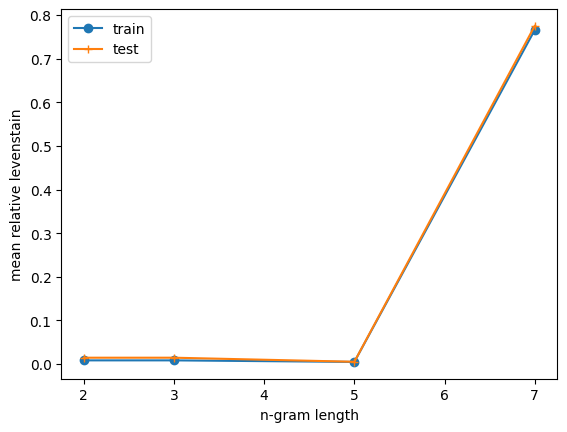

In [ ]:
plot_res(res)

Семплируй побольше, жди подольше и готово)

Но вообще заметно (не из графика, просто заметил пока делал), что чем больше длина n-gram, тем больше перестановок надо перебрать, чтобы сошлось к чему-то адекватному.